In [1]:
import os
import cv2
import json
import shutil

import numpy as np
import pandas as pd

from glob import glob

# Generate yolov8 txt format Binary Class

In [2]:
# img_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/*.jpg')
# json_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/jsons/*.json')

# img_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/BUSI/imgs/*.png')
# json_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/BUSI/jsons/*.json')

img_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/OASBUD/imgs/*.png')
json_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/OASBUD/jsons/*.json')

img_list.sort()
json_list.sort()

assert len(img_list) == len(json_list)

In [3]:
# txt_file_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts/"
# txt_file_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/BUSI/texts/"
txt_file_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/OASBUD/texts/"

for img_path, json_path in zip(img_list, json_list):
    assert os.path.basename(img_path)[:-4] == os.path.basename(json_path)[:-5]

    img_name = os.path.basename(img_path)[:-4]   # Same for .jpg and .png

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    with open(json_path, 'r') as f:
        json_data = json.load(f)
        assert h == json_data['imageHeight']
        assert w == json_data['imageWidth']
    
    for shape in json_data['shapes']:
        
        label = shape['label']

        # Treat 'benign' and 'malignant' as the same for binary classification
        if label == 'benign' or label == 'malignant':
            num_label = 0

        x_upper_left = shape['points'][0][0]
        y_upper_left = shape['points'][0][1]

        x_lower_right = shape['points'][1][0]
        y_lower_right = shape['points'][1][1]

        relative_x = (x_upper_left + x_lower_right) / 2 / w
        relative_y = (y_upper_left + y_lower_right) / 2 / h

        relative_box_width = (x_lower_right - x_upper_left) / w
        relative_box_height = (y_lower_right - y_upper_left) / h

        txt_save_path = os.path.join(txt_file_path, img_name + '.txt')

        with open(txt_save_path, 'a') as f:
            f.write(str(num_label) + ' ' + str(relative_x) + ' ' + str(relative_y) + ' ' + str(relative_box_width) + ' ' + str(relative_box_height) + '\n')


# Train-Test split

In [45]:
df = pd.read_csv("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/metadata_df_aiplus.csv")
df.head()

,image_name,image_type,image_height,image_width,label,dataset,case_id
0,04A195C7193647B599073C0FD2EF4D7D_2620171 (2),jpg,235,347,malignant,AIplus,1385682
1,051D402B1CE1483B9D6519C3CFE6CFAF_8277284,jpg,473,734,malignant,AIplus,13136661
2,051D402B1CE1483B9D6519C3CFE6CFAF_8277285,jpg,473,734,malignant,AIplus,13136661
3,051D402B1CE1483B9D6519C3CFE6CFAF_8277286,jpg,473,734,malignant,AIplus,13136661
4,1.2.826.0.1.3680043.2.461.10889799.1302130936,jpg,331,474,benign,AIplus,13121058


In [46]:
len(df)

1149

In [47]:
case_id_list = df['case_id'].tolist()

# Do a train-test split based on case_id, need to be random choice with random seed
np.random.seed(17)
train_case_id_list = np.random.choice(case_id_list, size=round(len(case_id_list) * 0.6), replace=False)




In [48]:
len(case_id_list)

1149

In [49]:
len(train_case_id_list)

689

In [50]:
# Set default split to train
df['split'] = 'test'

# Set train case_id to train

for case_id in train_case_id_list:
    df.loc[df['case_id'] == case_id, 'split'] = 'train'

<AxesSubplot:>

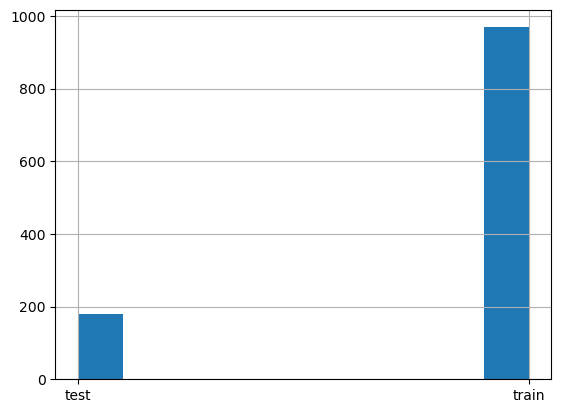

In [51]:
# show histogram of train-test split
df['split'].hist()

In [52]:
len(df[df['split'] == 'test']) / len(df)

0.1566579634464752

<AxesSubplot:>

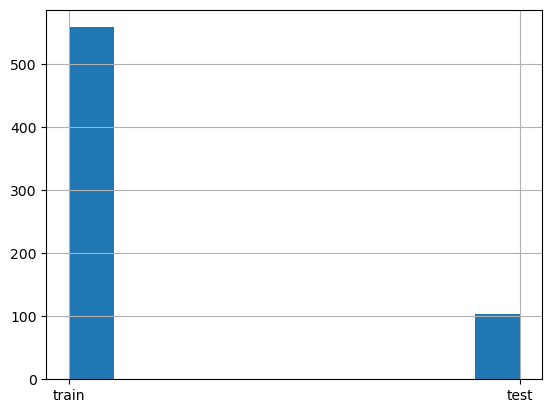

In [53]:
df[df['label'] == 'benign']['split'].hist()

<AxesSubplot:>

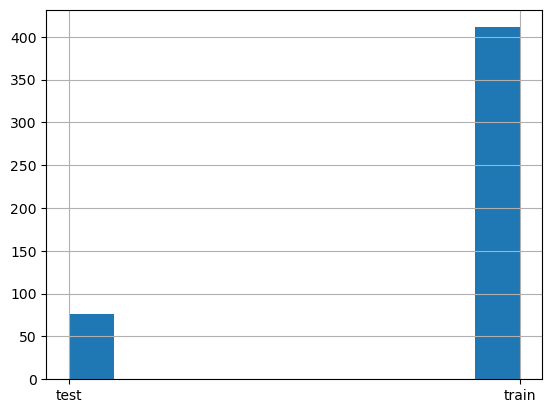

In [54]:
df[df['label'] == 'malignant']['split'].hist()

In [13]:
# Save updated dataframe
df.to_csv("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split/metadata_df_aiplus_split.csv", index=False)

In [14]:
df_train = df[df['split'] == 'train']
df_test = df[df['split'] == 'test']
# Copy training data to train folder
for image_name in df_train['image_name'].to_list():
    # Copy images for training set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/" + image_name + ".jpg",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split/images/train/" + image_name + ".jpg")

    # Copy txts for training set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts/" + image_name + ".txt",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split/labels/train/" + image_name + ".txt")
    
# Copy test data to test folder
for image_name in df_test['image_name'].to_list():
    # Copy images for test set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/" + image_name + ".jpg",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split/images/val/" + image_name + ".jpg")
    
    # Copy txts for test set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts/" + image_name + ".txt",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split/labels/val/" + image_name + ".txt")

# Create YOLOV8 Multiclass text format

In [14]:
# img_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/*.jpg')
# json_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/jsons/*.json')

# img_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/BUSI/imgs/*.png')
# json_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/BUSI/jsons/*.json')

img_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/OASBUD/imgs/*.png')
json_list = glob('C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/OASBUD/jsons/*.json')

img_list.sort()
json_list.sort()

assert len(img_list) == len(json_list)

In [15]:
txt_file_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/OASBUD/texts_mc/"

for img_path, json_path in zip(img_list, json_list):
    assert os.path.basename(img_path)[:-4] == os.path.basename(json_path)[:-5]

    img_name = os.path.basename(img_path)[:-4]   # Same for .jpg and .png

    img = cv2.imread(img_path)
    h, w, _ = img.shape

    with open(json_path, 'r') as f:
        json_data = json.load(f)
        assert h == json_data['imageHeight']
        assert w == json_data['imageWidth']
    
    if len(json_data['shapes']) > 1:
        print(img_name, len(json_data['shapes']))

    for shape in json_data['shapes']:
        
        label = shape['label']

        # Benign: 0, Malignant: 1
        if label == 'benign':
            num_label = 0
        elif label == 'malignant':
            num_label = 1

        x_upper_left = shape['points'][0][0]
        y_upper_left = shape['points'][0][1]

        x_lower_right = shape['points'][1][0]
        y_lower_right = shape['points'][1][1]

        relative_x = (x_upper_left + x_lower_right) / 2 / w
        relative_y = (y_upper_left + y_lower_right) / 2 / h

        relative_box_width = (x_lower_right - x_upper_left) / w
        relative_box_height = (y_lower_right - y_upper_left) / h

        txt_save_path = os.path.join(txt_file_path, img_name + '.txt')

        # Write multiple lines for multiple boxes
        with open(txt_save_path, 'a') as f:
            f.write(str(num_label) + ' ' + str(relative_x) + ' ' + str(relative_y) + ' ' + str(relative_box_width) + ' ' + str(relative_box_height) + '\n')

## Load pre-splitted dataframe

In [3]:
df = pd.read_csv("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split_binary/metadata_df_aiplus_split.csv")
df.head()

,image_name,image_type,image_height,image_width,label,dataset,case_id,split
0,04A195C7193647B599073C0FD2EF4D7D_2620171 (2),jpg,235,347,malignant,AIplus,1385682,test
1,051D402B1CE1483B9D6519C3CFE6CFAF_8277284,jpg,473,734,malignant,AIplus,13136661,train
2,051D402B1CE1483B9D6519C3CFE6CFAF_8277285,jpg,473,734,malignant,AIplus,13136661,train
3,051D402B1CE1483B9D6519C3CFE6CFAF_8277286,jpg,473,734,malignant,AIplus,13136661,train
4,1.2.826.0.1.3680043.2.461.10889799.1302130936,jpg,331,474,benign,AIplus,13121058,train


In [4]:
df_train = df[df['split'] == 'train']
df_test = df[df['split'] == 'test']
# Copy training data to train folder
for image_name in df_train['image_name'].to_list():
    # Copy images for training set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/" + image_name + ".jpg",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split_multiclass/images/train/" + image_name + ".jpg")

    # Copy txts for training set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_mc/" + image_name + ".txt",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split_multiclass/labels/train/" + image_name + ".txt")
    
# Copy test data to test folder
for image_name in df_test['image_name'].to_list():
    # Copy images for test set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/" + image_name + ".jpg",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split_multiclass/images/val/" + image_name + ".jpg")
    
    # Copy txts for test set
    shutil.copy("C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_mc/" + image_name + ".txt",
                "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split_multiclass/labels/val/" + image_name + ".txt")